In [1]:
import glob
import gzip
import nbt
import nbtlib
import numpy as np
import os
import PIL
import struct

In [2]:
from skimage.measure import block_reduce

In [3]:
import anvil
import minecraft_data

In [3]:
import matplotlib
import matplotlib.pyplot as plt
plt.show()
matplotlib.style.use( '/Users/zhafen/repos/clean-bold/clean-bold.mplstyle' )

In [4]:
import tqdm

In [13]:
CHUNK_SIZE = 16
CHUNKS_PER_REGION = 32
REGION_SIZE = CHUNK_SIZE * CHUNKS_PER_REGION

# Parameters

In [5]:
# world_dir = '/Users/zhafen/Downloads/MinecraftServer/TaniaWorld'
world_dir = '/Users/zhafen/Downloads/world'

In [27]:
image_norm = 'z'
norm_dim_value = 0

In [133]:
categories = {
    'greenery': [ 'acacia_leaves', 'acacia_log', 'grass', 'grass_block', 'glow_lichen' ],
    'empty': [ 'air', ],
    'stone': [ 'andesite', 'bedrock', 'deepslate', 'diorite', 'granite', 'sculk', 'sculk_vein', 'stone', 'tuff', ],
    'ore': [ 'coal_ore', 'copper_ore', 'deepslate_iron_ore', 'iron_ore', ],
    'dirt': [ 'dirt', 'gravel', ],
    'water': [ 'water', ],
}

In [134]:
category_colors = {
    'greenery': np.array([ 0., 1., 0., 1. ]),
    'empty': np.array([ 1., 1., 1., 0., ]),
    'stone': np.array([ 0.5, 0.5, 0.5, 1., ]),
    'ore': np.array([ 0., 0., 1., 1., ]),
    'dirt': np.array([ 1., 1., 0., 1., ]),
    'water': np.array([ 0., 0., 1., 1., ]),
    None: np.array([ 1., 0., 0., 1., ]),
}

# Make a Map

In [28]:
if image_norm == 'z':
    xdim = 'x'
    ydim = 'y'
elif image_norm == 'y':
    xdim = 'z'
    ydim = 'x'
elif image_norm == 'x':
    xdim = 'z'
    ydim = 'y'
else:
    raise KeyError( 'Unrecognized image_norm, image_norm = {}'.format( image_norm ) )

In [6]:
region_fps = glob.glob( os.path.join( world_dir, 'region', '*' ) )

In [7]:
i = 0
region_fp = region_fps[i]

In [15]:
region_fp = os.path.join( world_dir, 'region', 'r.0.0.mca' )

In [39]:
_, x_region, y_region, _ = os.path.basename( region_fp ).split( '.' )
x_region, y_region = int( x_region ), int( y_region )

In [20]:
region = anvil.Region.from_file( region_fp )
chunk_origin = anvil.Chunk.from_region( region, 0, 0 )

In [41]:
# Get the possible y values
section_height_range = anvil.chunk._section_height_range( chunk.version )
y_range = np.arange( section_height_range.start * CHUNK_SIZE, section_height_range.stop * CHUNK_SIZE )

In [81]:
# Convert indices to xs, ys, and zs, using index = y * 16**2 + z * 16 + x
inds = np.arange( 16**2 * y_range.size )

y_inds = inds // 16**2
z_inds = ( inds - y_inds * 16**2 ) // 16
x_inds = ( inds - y_inds * 16**2 - z_inds * 16 )

In [99]:
data_shape = ( REGION_SIZE, y_range.size )

In [122]:
# Extract string image
data = np.zeros( data_shape, dtype=int ).astype( str )
for x_chunk in tqdm.tqdm( range( CHUNKS_PER_REGION ) ):
    for z_chunk in range( CHUNKS_PER_REGION ):
        
            if z_chunk != norm_dim_value:
                continue
        
            # You can also provide the region file name instead of the object
            try:
                chunk = anvil.Chunk.from_region( region, x_chunk, z_chunk )
            except anvil.chunk.ChunkNotFound as e:
                missing_chunks.append( ( region_fp, x_chunk, z_chunk ) )
                continue
                
            for index, block in enumerate( chunk.stream_chunk() ):
                
                if z_inds[index] != 0:
                    continue
                
                data[x_chunk*16+x_inds[index],y_inds[index]] = block.id

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 17.33it/s]


In [135]:
data_palette = np.unique( data )
img = np.ones( ( data.shape[0], data.shape[1], 4 ) )
uncategorized_block_types = []
for block_type in data_palette:
    
    # Find the category
    block_category = None
    for category, category_blocks in categories.items():
        if block_type in category_blocks:
            block_category = category
            break
            
    if block_category is None:
        uncategorized_block_types.append( block_type )
    
    # Color in the image
    img[np.where( data==block_type )] = category_colors[block_category]

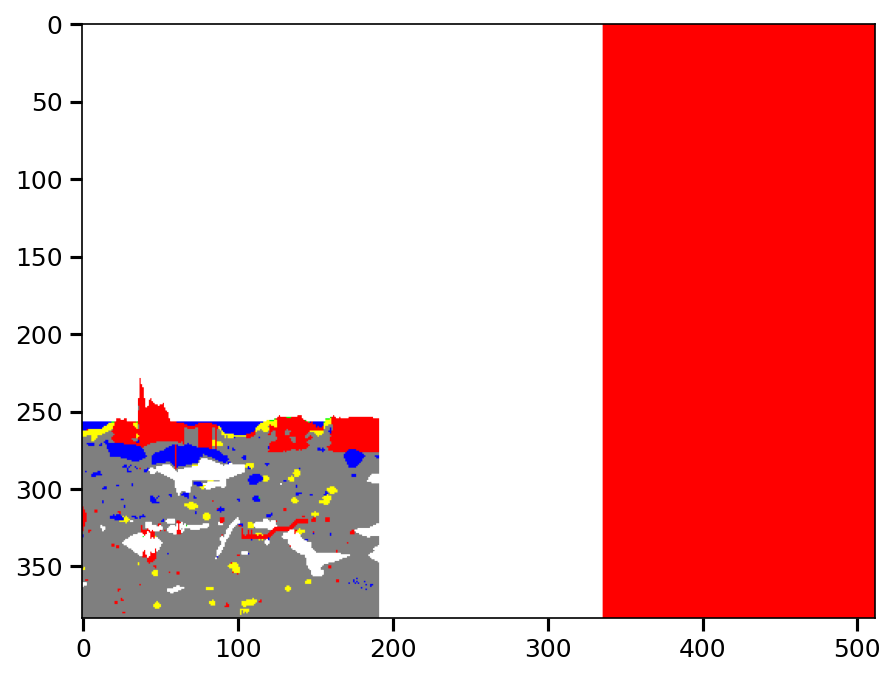

In [136]:
fig = plt.figure()
ax = plt.gca()

ax.imshow(
    np.rot90( img, axes=(0,1) ),
)

ax.set_aspect( 'equal' )

In [55]:
img

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [32]:
missing_chunks = []
chunk_positions = dict(
    i_chunks = [],
    j_chunks = [],
    x_chunks = [],
    z_chunks = [],
)
for x_chunk in range( CHUNKS_PER_REGION ):
    for z_chunk in range( CHUNKS_PER_REGION ):
        
            # You can also provide the region file name instead of the object
            try:
                chunk = anvil.Chunk.from_region( region, i_chunk, j_chunk )
            except anvil.chunk.ChunkNotFound as e:
                missing_chunks.append( ( region_fp, i_chunk, j_chunk ) )
                continue
                
            chunk_positions['i_chunks'].append( i_chunk )
            chunk_positions['j_chunks'].append( j_chunk )
            chunk_positions['x_chunks'].append( chunk.data['xPos'].value )
            chunk_positions['z_chunks'].append( chunk.data['zPos'].value )
            
for key, item in chunk_positions.items():
    chunk_positions[key] = np.array( item )

In [37]:
chunk_positions['j_chunks'] - chunk_positions['z_chunks']

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [34]:
chunk_positions['i_chunks'], chunk_positions['x_chunks']

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,
         7, 

In [25]:
missing_chunks = []
chunk_xs = []
chunk_ys = []
chunk_zs = []
for region_fp in tqdm.tqdm( region_fps ):
    
    region = anvil.Region.from_file( region_fp )
    
    # print( region_fp )
    
    for i_chunk in range( 32 ):
        for j_chunk in range( 32 ):

            # You can also provide the region file name instead of the object
            try:
                chunk = anvil.Chunk.from_region( region, i_chunk, j_chunk )
            except anvil.chunk.ChunkNotFound as e:
                missing_chunks.append( ( region_fp, i_chunk, j_chunk ) )
                # print( e )
                continue
                
            chunk_xs.append( chunk.data['xPos'].value )
            chunk_ys.append( chunk.data['yPos'].value )
            chunk_zs.append( chunk.data['zPos'].value )

  0%|                                                                                                                                                                                                                                  | 0/25 [00:00<?, ?it/s]


TypeError: '>' not supported between instances of 'NoneType' and 'int'

# Using Anvil-Parser

In [5]:
import anvil

In [6]:
region_fp = os.path.join( world_dir, 'region', 'r.0.0.mca' )

In [7]:
region_fps = glob.glob( os.path.join( world_dir, 'region', '*' ) )

In [8]:
i = 0
region_fp = region_fps[i]

In [9]:
region = anvil.Region.from_file( region_fp )

In [ ]:
# Get the possible y values
section_height_range = anvil.chunk._section_height_range( chunk.version )
y_range = np.arange( section_height_range.start * 16, section_height_range.stop * 16 )

In [ ]:
# Get the palette for the chunk
palette_chunk = set()
for i_section in section_height_range:
    block_palette_section = chunk.get_palette( i_section )
    palette_section = [ _.id for _ in block_palette_section ]
    palette_chunk = palette_chunk.union( palette_section )

In [ ]:
# Convert indices to xs, ys, and zs, using index = y * 16**2 + z * 16 + x
inds = np.arange( 16**2 * y_range.size )

y_inds = inds // 16**2
z_inds = ( inds - y_inds * 16**2 ) // 16
x_inds = ( inds - y_inds * 16**2 - z_inds * 16 )

In [ ]:
# Retrieve and format data for a chunk
data_cube = np.zeros( (16, y_range.size, 16 ) ).astype( str )
for index, block in enumerate( chunk.stream_chunk() ):
    data_cube[x_inds[index],y_inds[index],z_inds[index]] = block.id

In [ ]:
ind_x = 0
x_slice = data_cube[ind_x,:,:]

In [ ]:
img = np.zeros( x_slice.shape )
img[x_slice!='air'] = 1

In [ ]:
fig = plt.figure()
ax = plt.gca()

ax.pcolormesh(
    img,
    cmap = 'Greys',
)

ax.set_aspect( 'equal' )

In [ ]:
chunk.data['xPos']

In [11]:
missing_chunks = []
chunk_xs = []
chunk_ys = []
chunk_zs = []
for region_fp in tqdm.tqdm( region_fps ):
    
    region = anvil.Region.from_file( region_fp )
    
    # print( region_fp )
    
    for i_chunk in range( 32 ):
        for j_chunk in range( 32 ):

            # You can also provide the region file name instead of the object
            try:
                chunk = anvil.Chunk.from_region( region, i_chunk, j_chunk )
            except anvil.chunk.ChunkNotFound as e:
                missing_chunks.append( ( region_fp, i_chunk, j_chunk ) )
                # print( e )
                continue
                
            chunk_xs.append( chunk.data['xPos'].value )
            chunk_ys.append( chunk.data['yPos'].value )
            chunk_zs.append( chunk.data['zPos'].value )

  0%|                                                                                                                                                                                                                                  | 0/25 [00:00<?, ?it/s]


TypeError: '>' not supported between instances of 'NoneType' and 'int'

In [ ]:
fig = plt.figure()
ax = plt.gca()

ax.scatter(
    chunk_xs,
    chunk_zs,
    s = 1,
)

# ax.set_xlim( -50, 0 )
# ax.set_ylim( 0, 50 )

# Using PyAnvil

In [3]:
import pyanvil

In [4]:
world = pyanvil.World( world_dir )

In [11]:
world.get_block( (15, 10, 25) )

IndexError: list index out of range

In [8]:
chunk_data = world.get_chunk( ( 0, 0 ) )

In [10]:
chunk_data

# ChatGPT Scratch

In [ ]:
level = nbtlib.load( os.path.join( world_dir, 'level.dat' ) )

In [55]:
region_fps = glob.glob( os.path.join( world_dir, 'region', '*' ) )

In [62]:
i = -4
region_fp = region_fps[i]

In [99]:
region_fp = os.path.join( world_dir, 'region', 'r.0.0.mca' )

In [116]:
_, chunk_x, chunk_z, _ = os.path.basename( region_fp ).split( '.' )
chunk_x = int( chunk_x )
chunk_z = int( chunk_z )
chunk_x, chunk_z

(0, 0)

In [101]:
KB = 1024

In [130]:
region_fp

'/Users/zhafen/Downloads/world/region/r.0.0.mca'

In [143]:
with open( region_fp, 'rb' ) as mca_file:

    location_0 = mca_file.read( 100 )

In [157]:
location_0[:4].decode( 'utf-8' )

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x94 in position 2: invalid start byte

In [154]:
location_0.split( b'\x00' )

[b'',
 b'\x02\x94\x02',
 b'\x03O\x02',
 b'\x04\xe5\x03',
 b'',
 b' \x02',
 b'\x02\xbd\x02',
 b'\x02\xc7\x02',
 b'\x02\xf1\x02',
 b'\x03\x16\x02',
 b'\x03E\x02',
 b'',
 b'8\x02',
 b'\x032\x02',
 b'\x03\xf8\x01',
 b'\x04\x04\x01',
 b'\x03\xb1\x01',
 b'\x04\xd4\x01',
 b'\x04c\x01',
 b'\x03\xbd\x01',
 b'\x03\xf2\x01',
 b'\x03\xed\x01',
 b'\x04\xa2\x01',
 b'\x03\x88\x01',
 b'',
 b'',
 b'',
 b'',
 b'',
 b'',
 b'',
 b'',
 b'',
 b'',
 b'',
 b'',
 b'',
 b'',
 b'',
 b'']

In [126]:
location_0[-1]

2

In [129]:
location_0[:3]

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x94 in position 2: invalid start byte

In [111]:
import struct

# define constants
SECTOR_SIZE = 4096
CHUNK_HEADER_SIZE = 5

with open( region_fp, 'rb' ) as mca_file:

    mca_file.seek( 8 * KB )
    
    # read the chunk offset from the region file
    chunk_offset_bytes = mca_file.read(4)
    chunk_offset = struct.unpack('>i', chunk_offset_bytes)[0]

    # read the chunk length from the region file
    chunk_length_bytes = mca_file.read(1)
    chunk_length = chunk_length_bytes[0]
    
    # read the chunk data from the region file
    chunk_data = mca_file.read(chunk_length * SECTOR_SIZE - CHUNK_HEADER_SIZE)

In [105]:
chunk_offset_bytes

b'\x00\x00\x11\xe6'

In [87]:
# Constants
SECTOR_SIZE = 4096  # 4 KiB

In [88]:
def get_chunk_offset(chunk_x, chunk_z):
    """
    Calculate the offset of the chunk within the file.
    """
    # Each chunk's header is 5 bytes long
    header_size = 5

    # Calculate the offset of the chunk within the file
    chunk_offset = (chunk_x % 32) + (chunk_z % 32) * 32
    return chunk_offset * header_size

In [89]:
# Calculate the offset of the chunk within the file
sector_offset = get_chunk_offset(chunk_x, chunk_z)
byte_offset = sector_offset * SECTOR_SIZE

In [95]:
sector_offset = 1
byte_offset = sector_offset * SECTOR_SIZE

In [96]:
byte_offset

4096

In [97]:
with open( region_fp, 'rb' ) as mca_file:

    # Read the chunk header
    # mca_file.seek(byte_offset)
    chunk_header = mca_file.read(5)
    
    chunk_length = struct.unpack('>i', chunk_header[0:4])[0]
    compression_type = chunk_header[4]
    
    # Read the chunk data from the file
    chunk_data = mca_file.read(chunk_length)
    
    # Decompress the chunk data if necessary
    compression_scheme = chunk_header[4]
    if compression_scheme == 1:
        chunk_data = gzip.decompress(chunk_data)
        
    # Parse the NBT data
    chunk_data_str = chunk_data.decode( 'utf-16' )
    chunk_nbt = nbtlib.parse_nbt( chunk_data_str[1:] )

InvalidLiteral: Unexpected end of input at position 0

In [20]:
struct.unpack('>i', chunk_header[:4])

(7425,)

In [50]:
import nbt

# Open the .mca file
with open(region_fp, "rb") as f:
    # Read the file contents into a buffer
    data = f.read()

    # Parse the buffer as an NBT file
    nbtfile = nbt.NBTFile(buffer=data)

AttributeError: module 'nbt' has no attribute 'NBTFile'

In [49]:
chunk_data.decode( 'utf-8' )

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xbf in position 13: invalid start byte

In [14]:
import nbtlib
import struct

# Constants
SECTOR_SIZE = 4096  # 4 KiB

def get_chunk_offset(chunk_x, chunk_z):
    """
    Calculate the offset of the chunk within the file.
    """
    # Each chunk's header is 5 bytes long
    header_size = 5

    # Calculate the offset of the chunk within the file
    chunk_offset = (chunk_x % 32) + (chunk_z % 32) * 32
    return chunk_offset * header_size

def load_chunk_data(mca_file, chunk_x, chunk_z):
    """
    Load a chunk's data from a .mca file.
    """
    # Calculate the offset of the chunk within the file
    sector_offset = get_chunk_offset(chunk_x, chunk_z)
    byte_offset = sector_offset * SECTOR_SIZE

    # Read the chunk header
    mca_file.seek(byte_offset)
    chunk_header = mca_file.read(5)
    if not chunk_header:
        return None
    length = struct.unpack('>i', chunk_header[:4])[0]
    compression_type = chunk_header[4]

    # Read the chunk data
    chunk_data = mca_file.read(length)
    if not chunk_data:
        return None

    if compression_type == 1:  # gzip compression
        # Use gzip to decompress the data
        chunk_data = gzip.decompress(chunk_data)
        
    # return chunk_data

    # Load the chunk data into nbtlib
    # try:
    return nbtlib.parse_nbt(chunk_data.decode('utf-8'))
    # except BaseException as e:
    #     print(f"Error loading chunk ({chunk_x}, {chunk_z}): {e}")
    #     return None

def save_chunk_data(mca_file, chunk_x, chunk_z, chunk_data):
    """
    Save a chunk's data to a .mca file.
    """
    # Calculate the offset of the chunk within the file
    sector_offset = get_chunk_offset(chunk_x, chunk_z)
    byte_offset = sector_offset * SECTOR_SIZE

    # Serialize the chunk data
    serialized_data = nbtlib.serialize_nbt(chunk_data, compressed=True)

    # Calculate the length of the chunk data and the compression type
    length = len(serialized_data)
    compression_type = 1  # gzip compression

    # Write the chunk header
    mca_file.seek(byte_offset)
    mca_file.write(struct.pack('>i', length))
    mca_file.write(bytes([compression_type]))

    # Write the compressed chunk data
    mca_file.write(gzip.compress(serialized_data))


In [15]:
with open( region_fp, 'rb' ) as mca_file:
    chunk_data = load_chunk_data( mca_file, chunk_x, chunk_z )

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xbf in position 13: invalid start byte